In [1]:

import joblib 

from sklearn import metrics
from sklearn.metrics import f1_score, hamming_loss, precision_score, recall_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Corpus Processing
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')

from nltk import word_tokenize, sent_tokenize # tokenizing
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\olkos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\olkos\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# importing necessary libraries to manipulate the data sources 
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# loading dataset
reviews = pd.read_csv("annotated_data_topic_classification.csv", encoding='utf-8')
reviews.head(5)

,index,custom_comment,sentiment,1 Pricing and Fairness,2 Driver professionalism,3 Driver behaviour,4 Customer Service,5 Application,6 Lost things,7 Vehicle Condition,8 Safety & reliability,9 General bad,10 Other
0,49,The driver didn’t pay back the rest of the money,-1,1,0,1,0,0,0,0,0,0,0
1,2247,He is the worst driver in Utaxi and I would de...,-1,0,0,1,0,0,0,0,0,0,0
2,2272,A simple “hello” or response would be perfect....,-1,0,0,1,0,0,0,0,0,0,0
3,3229,Not so great service,-1,0,0,0,0,0,0,0,0,1,0
4,3576,"Worst driver ever, he’s a racist was screaming...",-1,0,0,1,0,0,0,0,0,0,0


#### Exploratory Data Analysis (EDA)

In [4]:
print("Number of rows in data =", reviews.shape[0])
print("Number of columns in data =", reviews.shape[1])

Number of rows in data = 4760
Number of columns in data = 13


In [5]:
# Checking for missing values
missing_values_check = reviews.isnull().sum()
print(missing_values_check)

index                       0
custom_comment              0
sentiment                   0
1 Pricing and Fairness      0
2 Driver professionalism    0
3 Driver behaviour          0
4 Customer Service          0
5 Application               0
6 Lost things               0
7 Vehicle Condition         0
8 Safety & reliability      0
9 General bad               0
10 Other                    0
dtype: int64


In [6]:
categories = reviews.columns.values[3:]
categories = categories.tolist()

print(categories)

['1 Pricing and Fairness', '2 Driver professionalism', '3 Driver behaviour', '4 Customer Service', '5 Application', '6 Lost things', '7 Vehicle Condition', '8 Safety & reliability', '9 General bad', '10 Other']


In [7]:
# Calculating number of comments in each category

counts = []
for category in categories:
    counts.append((category, reviews[category].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number of comments'])
df_stats

,category,number of comments
0,1 Pricing and Fairness,1189
1,2 Driver professionalism,1708
2,3 Driver behaviour,1933
3,4 Customer Service,211
4,5 Application,108
5,6 Lost things,82
6,7 Vehicle Condition,247
7,8 Safety & reliability,542
8,9 General bad,142
9,10 Other,347


Text(0.5, 0, 'Comment Type ')

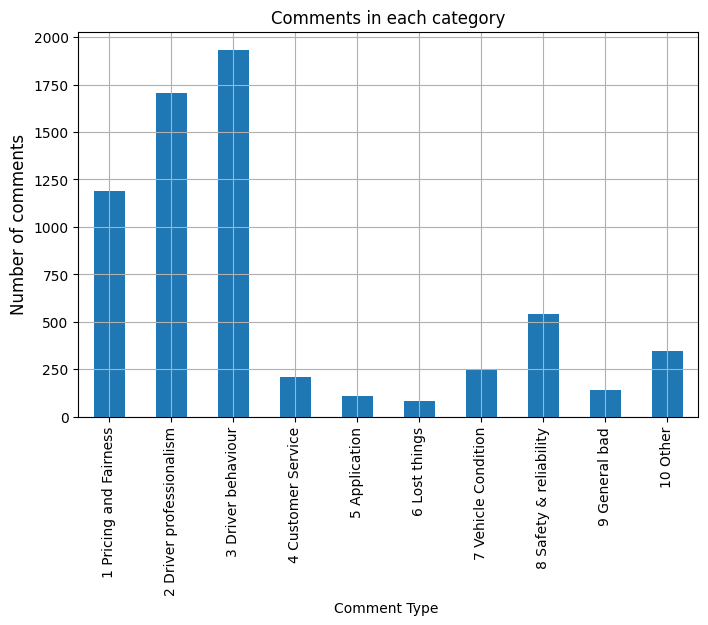

In [8]:
df_stats.plot(x='category', y='number of comments', kind='bar', legend=False, grid=True, figsize=(8, 5))

plt.title("Comments in each category", fontsize=12)
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Comment Type ', fontsize=10)


<AxesSubplot:>

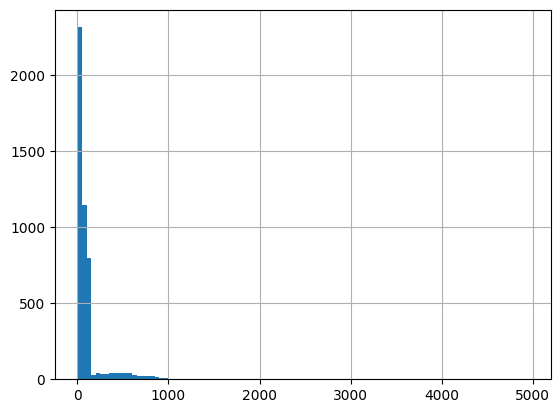

In [10]:
lens = reviews.custom_comment.str.len()
lens.hist(bins = np.arange(0,5000,50))

#### data cleaning & preprocessing:

In [11]:
stopwords = ['a', 'about', 'an', 'am' 'and', 'are', 'as', 'at', 'be', 'been', 'but', 'by', 'can', \
             'even', 'ever', 'for', 'from', 'get', 'had', 'has', 'have', 'he', 'her', 'hers', 'his', \
             'how', 'i', 'if', 'in', 'into', 'is', 'it', 'its', 'just', 'me', 'my', 'of', 'on', 'or', \
             'see', 'seen', 'she', 'so', 'than', 'that', 'the', 'their', 'there', 'they', 'this', \
             'to', 'was', 'we', 'were', 'what', 'when', 'which', 'who', 'will', 'with', 'you']


short_forms = {
    "don't": "do not",
    "can't": "cannot",
    "won't": "will not",
    "shouldn't": "should not",
    "wouldn't": "would not",
    "didn't": "did not",
    "doesn't": "does not",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "hasn't": "has not",
    "haven't": "have not",
    "it's": "it is",
    "I'm": "I am",
    "you're": "you are",
    "he's": "he is",
    "she's": "she is",
    "we're": "we are",
    "they're": "they are",
    "I've": "I have",
    "you've": "you have",
    "we've": "we have",
    "they've": "they have",
    "couldn't": "could not",
    "should've": "should have",
    "would've": "would have",
    "might've": "might have",
    "must've": "must have",
    # Add more short forms and their full forms as needed
}

def replace_short_forms(text):
    # Create a regular expression pattern to match short forms as standalone words
    pattern = r'\b(?:{})\b'.format('|'.join(short_forms.keys()), re.IGNORECASE)
    
    # Replace short forms with their corresponding full forms using a lambda function
    full_forms_text = re.sub(pattern, lambda match: short_forms[match.group(0)], text)
    
    return full_forms_text


# (?) remove quotation marks, unnecessary punctuation, [{}[]\/+*%|^%#@!?()]
def punctuation_remover(text):
    pattern = r'[{}\[\]\\\/\+\*%\|\^%#@\(\)\$\"]'
    return re.sub(pattern, ' ', text)

# lemmatizing, tokenization, isalpha, stopwords
def lemma_stopwords_token(text):
      le=WordNetLemmatizer()
      word_tokens=nltk.word_tokenize(text)
      word_tokens =[token for token in word_tokens if token.isalpha()]
      tokens=[le.lemmatize(token) for token in word_tokens if token not in stopwords and len(token)>2]
      processed_text =" ".join(tokens)
      return processed_text


# main preprocessing function
def preprocessing(text):
    reviews = replace_short_forms(text)
    reviews = punctuation_remover(reviews)
    reviews = lemma_stopwords_token(text)
    return reviews


#### data split

In [15]:
# download reviews from dataset and preprocess them
data = [preprocessing(custom_comment) for custom_comment in reviews['custom_comment'].to_list()]


topics = reviews.columns.values[3:]
topics = topics.tolist()
labels = reviews[topics].values


In [18]:
# Extract features from the preprocessed data and fit it
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(data)

In [19]:
# Split the data into training and testing sets using features
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# # Split the data into training and testing sets using raw text
# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

using different approaches to splitting data

In [36]:
# !pip install iterative-stratification

In [55]:
from skmultilearn.model_selection import iterative_train_test_split
# X_train, y_train, X_test, y_test = iterative_train_test_split(features, labels, test_size = 0.5)

In [69]:
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
binary_topics = mlb.fit_transform(topics)
# print(binary_topics)

# ?? 
X_train, X_test, y_train, y_test = iterative_train_test_split(features, binary_topics, test_size=0.2)


In [56]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# mskf = MultilabelStratifiedKFold(n_splits=2, shuffle=True, random_state=0)

# for train_index, test_index in mskf.split(features, labels):
#    # print("TRAIN:", train_index, "TEST:", test_index)
#    X_train, X_test = features[train_index], features[test_index]
#    y_train, y_test = labels[train_index], labels[test_index]

#### Pipeline to  fit & train the model,  run predictions and analyze the results 

**Naive Bayes**

 *Naive Bayes supports multi-class, but we are in a multi-label scenario, therefore, we wrapp Naive Bayes in the OneVsRestClassifier.*


In [20]:
NB_pipeline = Pipeline([('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None)))])

NB_pipeline.fit(X_train, y_train)
prediction = NB_pipeline.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test, prediction)))


Test accuracy is 0.5252100840336135


**Logistic Regression**

In [21]:
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])

LogReg_pipeline.fit(X_train, y_train)
prediction = LogReg_pipeline.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test, prediction)))

Test accuracy is 0.5546218487394958


In [25]:
# Save the trained model for later use
joblib.dump(LogReg_pipeline, 'model_topic_classification_LogReg.joblib')

['model_topic_classification_LogReg.joblib']

**LinearSVC**

In [22]:
# SVC_pipeline = Pipeline([
#                 ('tfidf', TfidfVectorizer()),
#                 ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
#             ])
SVC_pipeline = OneVsRestClassifier(LinearSVC(), n_jobs=1)

SVC_pipeline.fit(X_train, y_train)
prediction = SVC_pipeline.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test, prediction)))

Test accuracy is 0.6207983193277311


In [26]:
# Save the trained model for later use
joblib.dump(SVC_pipeline, 'model_topic_classification_SVC.joblib')

# Load the saved model and classify new news examples
# clf = joblib.load('model_topic_classification.joblib')

['model_topic_classification_SVC.joblib']

In [23]:
loaded_model = joblib.load('model_topic_classification_SVC.joblib')
# loaded_model2 = joblib.load('model_LabelPowerset_classification.joblib')

def prepare_new_reviews(text):
  """
  Prepare new text for model testing: preprocess it, vectorize, predict label and return it
  """
  text = preprocessing(text)
  feature = vectorizer.transform([text])
  prediction = loaded_model.predict(feature)
  
  topics = ['1 Pricing and Fairness', '2 Driver professionalism', '3 Driver behaviour', '4 Customer Service', '5 Application', '6 Lost things', '7 Vehicle Condition', '8 Safety & reliability', '9 General bad', '10 Other']
  predicted_topics = []
  for i, topic in enumerate(topics):
    if prediction[0,i] == 1:
    # if prediction[0][i] == 1:
      predicted_topics.append(topic)
  return predicted_topics
  

# in this list you can indicate which news to classify
reviews_example = [
  "The driver started idle",
                """driver is a cheat""",
                """The drivers behaviour is inappropriate""",
                """I had a couple of rides with your service before and they were nice, but this time there wasn't a seatbelt which I believe is totally not OK. and the driver just said Are yoou going or not??""",
                """I lost my laptop!""",
                """driver is a cheat. I lost my laptop!""",
                """bad""",
                """your customer service never replies""",
                """bad smell""",
                """want refund"""]

for i, review in enumerate(reviews_example):
  # print(f"{review[0]}. {prepare_new_reviews(review[1])}")
  print(f"{i}. {review}")
  print(f"  - Predicted as: '{prepare_new_reviews(review)}'")
  print("")


0. The driver started idle
  - Predicted as: '['1 Pricing and Fairness']'

1. driver is a cheat
  - Predicted as: '['1 Pricing and Fairness', '3 Driver behaviour']'

2. The drivers behaviour is inappropriate
  - Predicted as: '['3 Driver behaviour']'

3. I had a couple of rides with your service before and they were nice, but this time there wasn't a seatbelt which I believe is totally not OK. and the driver just said Are yoou going or not??
  - Predicted as: '['3 Driver behaviour']'

4. I lost my laptop!
  - Predicted as: '[]'

5. driver is a cheat. I lost my laptop!
  - Predicted as: '['3 Driver behaviour']'

6. bad
  - Predicted as: '['9 General bad']'

7. your customer service never replies
  - Predicted as: '['4 Customer Service']'

8. bad smell
  - Predicted as: '['7 Vehicle Condition']'

9. want refund
  - Predicted as: '['1 Pricing and Fairness']'



#### adding SMOTE Technique *(Synthetic Minority Oversampling Technique)*

In [ ]:
# !pip install imbalanced-learn

In [26]:
# from imblearn.over_sampling import MLkNN 
# from collections import Counter
# from sklearn.preprocessing import LabelEncoder

# # label encode the target variable
# # y_train = LabelEncoder().fit_transform(y_train)


# counter = Counter(tuple(label) for label in y_train)
# print('Before', counter)

# # oversampling the train dataset using SMOTE
# mlsmote = MLkNN()

# #X_train, y_train = smt.fit_resample(X_train, y_train)
# X_train_resampled, y_train_resampled = mlsmote.fit_resample(X_train, y_train)

# counter = Counter(y_train_resampled)
# for k,v in counter.items():
#     per = v / len(y) * 100
#     print('Class=%d, n=%d (%.3f%%)' % (k, v, per))


#### extra training

In [27]:
# !pip install scikit-multilearn

In [ ]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

BinaryRelevance_pipeline = Pipeline([
                ('clf', BinaryRelevance(LogisticRegression(solver='sag'))),
            ])


BinaryRelevance_pipeline.fit(X_train, y_train)
prediction = BinaryRelevance_pipeline.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test, prediction)))
print('F1 score is ',f1_score(y_test, prediction, average="micro"))
print('Hamming Loss is ', hamming_loss(y_test, prediction))

In [ ]:
# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset

# initialize label powerset multi-label classifier
LabelPowerset_pipeline = Pipeline([
                ('clf', LabelPowerset(LogisticRegression(solver='sag'))),
            ])

LabelPowerset_pipeline.fit(X_train, y_train)
prediction = LabelPowerset_pipeline.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test, prediction)))
print('F1 score is ',f1_score(y_test, prediction, average="micro"))
print('Hamming Loss is ', hamming_loss(y_test, prediction))



In [31]:
# Save the trained model for later use
joblib.dump(LabelPowerset_pipeline, 'model_LabelPowerset_classification.joblib')

['model_LabelPowerset_classification.joblib']

In [ ]:
from skmultilearn.problem_transform import ClassifierChain

ClassifierChain_pipeline = Pipeline([
                ('clf', ClassifierChain(LogisticRegression(solver='sag'))),
            ])


ClassifierChain_pipeline.fit(X_train, y_train)
prediction = ClassifierChain_pipeline.predict(X_test)
print('Test accuracy is {}'.format(accuracy_score(y_test, prediction)))
print('F1 score is ',f1_score(y_test, prediction, average="micro"))
print('Hamming Loss is ', hamming_loss(y_test, prediction))

In [ ]:

# for category in categories:
#     print('... Processing {}'.format(category))
#     # train the model using X_dtm & y
#     NB_pipeline.fit(X_train, train[category])
#     # compute the testing accuracy
#     prediction = NB_pipeline.predict(X_test)
#     print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing 1 Pricing and Fairness
Test accuracy is 0.8602941176470589
... Processing 2 Driver professionalism
Test accuracy is 0.8319327731092437
... Processing 3 Driver behaviour
Test accuracy is 0.8476890756302521
... Processing 4 Customer Service
Test accuracy is 0.9632352941176471
... Processing 5 Application
Test accuracy is 0.9810924369747899
... Processing 6 Lost things
Test accuracy is 0.9810924369747899
... Processing 7 Vehicle Condition
Test accuracy is 0.9537815126050421
... Processing 8 Safety & reliability
Test accuracy is 0.9012605042016807
... Processing 9 General bad
Test accuracy is 0.9705882352941176
... Processing 10 Other
Test accuracy is 0.9978991596638656
